In [1]:
import warnings
warnings.filterwarnings("ignore")

from simulation.loopix import *
from simulation.apps import *
from simulation.messages import *
from simulation.multicast import *
from simulation.notebook_utils import *
import simulation.simrandom

import gc
import gzip
import itertools
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
import os
import pickle
import pprint
import statistics
import sys
import time

from collections import namedtuple

%config InlineBackend.figure_format = 'retina'

# Avoid type 3 fonts
plt.rc('pdf', fonttype=42)

In [2]:
class SimResult(object):
    
    def __init__(self, m, group_sizes, config_name, schedule_name, strategy_name):
        self.name = get_name(m, group_sizes, config_name, schedule_name, strategy_name)
        self.m = m
        self.group_sizes = group_sizes
        self.config_name = config_name
        self.schedule_name = schedule_name
        self.strategy_name = strategy_name
        self.sim_time_ms = 0
        
    def output_filename(self):
        return os.path.join('pickles', self.name + ".output")
    
    def __repr__(self):
        return self.name

# Loading

In [3]:
def read_data(groupsizes, configs, schedules, strategies):
    data = []
    for m, group_sizes in groupsizes:
        for config_name in configs:
            for schedule_name in schedules:
                for strategy_name in strategies:
                    data.append(SimResult(m, group_sizes, config_name, schedule_name, strategy_name))
    return data

# [!] CHANGE `24` to `1` for shorter simulations
DEFAULT_MS = 24 * 3600 * 1000

DEFAULT_SCHEDULES = ['gen_os10', 'gen_os15', 'gen_os20']

In [4]:
# ONLINE scenarios
ONLINE_GROUP_SIZES = [
    (32, [32]),
    (45, [45]),
    (64, [64]),
    (91, [91]),
    (128, [128]),
    (181, [181]),
    (256, [256]),
]
ONLINE_CONFIGS = ['rs']
ONLINE_SCHEDULES = ['online']
ONLINE_STRATEGIES = ['unicast', 'rollercoaster-k1-p1-notimeout', 'rollercoaster-k2-p2-notimeout']

online_data = read_data(ONLINE_GROUP_SIZES, ONLINE_CONFIGS, ONLINE_SCHEDULES, ONLINE_STRATEGIES)

In [5]:
# OFFLINE scenarios
OFFLINE_GROUP_SIZES = [
    (128, [128]),
    (256, [256]),
]
OFFLINE_SCHEDULES = ['gen_os10', 'gen_os15', 'gen_os20']
OFFLINE_CONFIGS = ['rs']
OFFLINE_SCHEDULES = DEFAULT_SCHEDULES[:]
OFFLINE_STRATEGIES = [
    'unicast',
    'rollercoaster-k2-p2-notimeout',
    'rollercoaster-k1-p1-timeout10x-dropoffline',
    'rollercoaster-k2-p2-timeout10x-dropoffline',
]

# and for the histograms
OFFLINE_HIST_GROUP_SIZES = [(128, [128])]
OFFLINE_HIST_STRATEGIES = OFFLINE_STRATEGIES + ['rollercoaster-k2-p2-timeout10x'] 

offline_data = read_data(OFFLINE_GROUP_SIZES, OFFLINE_CONFIGS, OFFLINE_SCHEDULES, OFFLINE_STRATEGIES)
offline_hist_data = read_data(OFFLINE_HIST_GROUP_SIZES, OFFLINE_CONFIGS, OFFLINE_SCHEDULES, OFFLINE_HIST_STRATEGIES)

In [6]:
# MULTIGROUP scenarios
MULTIGROUP_GROUP_SIZES = [
    (128, [128]*1),
    (128, [128]*2),
    (128, [128]*4),
    (128, [128]*8),
    (128, [128]*16),
]
MULTIGROUP_CONFIGS = ['rs']
MULTIGROUP_SCHEDULES = ['online', 'gen_os15']
MULTIGROUP_STRATEGIES = [
    'unicast',
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p2-timeout10x-dropoffline', 
]

multigroup_data = read_data(MULTIGROUP_GROUP_SIZES, MULTIGROUP_CONFIGS, MULTIGROUP_SCHEDULES, MULTIGROUP_STRATEGIES)

In [7]:
# MULTIMESSAGE scenarios
MULTIMESSAGE_GROUP_SIZES = [
    (128, [128])
]
MULTIMESSAGE_CONFIGS = ['rs', 'rs-m2', 'rs-m4', 'rs-m8', 'rs-m16', 'rs-m32']
MULTIMESSAGE_SCHEDULES = ['online', 'gen_os15']
MULTIMESSAGE_STRATEGIES = [
    'unicast',
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p2-timeout10x-dropoffline', 
]

multimessage_data = read_data(MULTIMESSAGE_GROUP_SIZES, MULTIMESSAGE_CONFIGS, MULTIMESSAGE_SCHEDULES, MULTIMESSAGE_STRATEGIES)

In [8]:
# P scenarios
P_GROUP_SIZES = [
    (128, [128]),
]
P_CONFIGS = ['rs', 'rs-l2', 'rs-l4', 'rs-l8', 'rs-l16']
P_SCHEDULES = ['online', 'gen_os10', 'gen_os15', 'gen_os20']
P_STRATEGIES = [
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p2-timeout10x-dropoffline', 
    'rollercoaster-k4-p4-timeout10x-dropoffline', 
    'rollercoaster-k8-p8-timeout10x-dropoffline', 
    'rollercoaster-k16-p16-timeout10x-dropoffline', 
    'rollercoaster-k2-p1-timeout10x-dropoffline', 
    'rollercoaster-k4-p1-timeout10x-dropoffline', 
    'rollercoaster-k8-p1-timeout10x-dropoffline', 
    'rollercoaster-k16-p1-timeout10x-dropoffline', 
]

p_data = read_data(P_GROUP_SIZES, P_CONFIGS, P_SCHEDULES, P_STRATEGIES)

In [9]:
all_datas = [online_data, offline_data, multigroup_data, multimessage_data, p_data]

In [10]:
def load_results(data, incl_scatter=False):
    start = time.time()
    for sr in data:
        npz_filename = sr.output_filename() + '.npz'
        sys.stdout.write('.')
        sys.stdout.flush()
        
        with np.load(npz_filename) as npz:
            sr.sim_time_ms = npz['sim_time_ms'][0]

            sr.e2e_entries_d = npz['e2e_entries_d']
            sr.e2e_entries_online_d = npz['e2e_entries_online_d']
            if incl_scatter:
                sr.e2e_entries_t = npz['e2e_entries_t']
                sr.e2e_entries_online_t = npz['e2e_entries_online_t']
#             sr.already_seen = npz['already_seen']
#             sr.payload_buffer_levels = npz['payload_buffer_levels']
#             sr.payload_buffer_levels_t = npz['payload_buffer_levels_t']
        del npz
    print("\nLoaded #data:", len(data), "(%.1fs)" % (time.time() - start))
    
load_results(online_data, incl_scatter=False)
load_results(offline_data, incl_scatter=False)
load_results(offline_hist_data, incl_scatter=False)
load_results(multigroup_data, incl_scatter=False)
load_results(multimessage_data, incl_scatter=False)
load_results(p_data, incl_scatter=False)

.....................
Loaded #data: 21 (0.5s)
........................
Loaded #data: 24 (0.8s)
...............
Loaded #data: 15 (0.3s)
..............................
Loaded #data: 30 (3.1s)
....................................
Loaded #data: 36 (6.0s)
....................................................................................................................................................................................
Loaded #data: 180 (4.7s)


In [11]:
def print_stats(name, data):
    print()
    print("-- %s --" % name.upper())
    total_sim_time = int(sum([sim.sim_time_ms for sim in data])/3_600_000)
    total_count_messages = sum([len(sim.e2e_entries_d) for sim in data])
    total_count_messages_online = sum([len(sim.e2e_entries_online_d) for sim in data])
    print(f"Total simulated time (walltime hours): {total_sim_time:,}")
    print(f"Total messages: {total_count_messages:,}")
    print(f"Total messages (online-only): {total_count_messages_online:,}")
    
print_stats(
    "TOTAL",
    online_data + offline_data + offline_hist_data + multigroup_data + multimessage_data + p_data
)


-- TOTAL --
Total simulated time (walltime hours): 7,344
Total messages: 265,556,420
Total messages (online-only): 223,859,930


# Definitons

In [12]:
#
# Filter methods
#

def filter_results(data, **kwargs):
    result = []
    for r in data:
        match = True
        for k, v in kwargs.items():
            if getattr(r, k) != v:
                match = False
                break
        if match:
            result.append(r)
    return result

Row = namedtuple('Row', ['label', 'value', 'cols'])
Col = namedtuple('Col', ['label', 'value', 'd'])

def group_results(data, y_grouping, y_values, x_grouping, x_values):
    assert x_grouping != y_grouping
    
    rows = []
    for y_value in y_values:
        row = Row(get_category_value_label(y_grouping, y_value), y_value, [])
        rows.append(row)
        
        for x_value in x_values:
            d = filter_results(data, **{y_grouping: y_value, x_grouping: x_value})
            assert len(d) == 1, "len(d)==%d, y_value=%s, x_value=%s" % (len(d), str(y_value), str(x_value))
            
            row.cols.append(Col(get_category_value_label(x_grouping, x_value), x_value, d))
            
    return rows

In [13]:
#
# Labels and colours
#

def get_category_value_label(category, value):
    if category == 'm':
        return ' $m=%s$' % str(value)
    elif category == 'strategy_name':
        substrings = {
            # default
            'unicast': "Unicast",
            'rollercoaster-k1-p1-notimeout': "RC ($k=p=1$)",
            'rollercoaster-k2-p2-notimeout': "RC ($k=p=2$)",
            'rollercoaster-k1-p2-notimeout': "RC ($k=1, p=2$)",
            'rollercoaster-k2-p1-notimeout': "RC ($k=2, p=1$)",
            'rollercoaster-k3-p3-notimeout': "RC ($k=p=3$)",
            
            # offline (more specific first)
            'rollercoaster-k2-p2-timeout05x-dropoffline': "RC-FT ($k=p=2, t_{out}=0.5x$)",
            'rollercoaster-k2-p2-timeout10x-dropoffline': "RC-FT ($k=p=2$)",
            'rollercoaster-k2-p2-timeout15x-dropoffline': "RC-FT ($k=p=2, t_{out}=1.5x$)",
            'rollercoaster-k2-p2-timeout20x-dropoffline': "RC-FT ($k=p=2, t_{out}=2.0x$)",
            
            'rollercoaster-k1-p1-timeout10x-dropoffline': "RC-FT ($k=p=1$)",
            
            'rollercoaster-k2-p2-timeout05x': "RC-FT ($k=p=2, t_{out}=0.5x$, w/o drop)",
            'rollercoaster-k2-p2-timeout10x': "RC-FT ($k=p=2$, w/o drop)",
            'rollercoaster-k2-p2-timeout15x': "RC-FT ($k=p=2, t_{out}=1.5x$, w/o drop)",
            'rollercoaster-k2-p2-timeout20x': "RC-FT ($k=p=2, t_{out}=2.0x$, w/o drop)",
        }
        for ss, vv in substrings.items():
            if ss in value:
                return vv
    elif category == 'config_name':
        try:
            return {
                'rs': " $1$",
                'rs-m2': " $2$",
                'rs-m4': " $4$",
                'rs-m8': " $8$",
                'rs-m16': " $16$",
                'rs-m32': " $32$",
            }[value]
        except KeyError:
            return str(value)
    elif category == 'schedule_name':
        return {
            'gen_os10': " $65\\%$ online",
            'gen_os15': " $80\\%$ online",
            'gen_os20': " $88\\%$ online",
            'online': " $100\\%$ online",
        }[value]
    elif category == 'group_sizes':
        return len(value)
        
    else:
        assert False, "unknown category %s" % str(category)

cmap = plt.get_cmap("tab20")      
def get_color(category, value):
    if category == 'strategy_name':
        substrings = {
            # default
            'unicast': cmap(0),
            'rollercoaster-k1-p1-notimeout': cmap(5),
            'rollercoaster-k1-p2-notimeout': cmap(14-8),
            'rollercoaster-k2-p1-notimeout': cmap(15-8),
            'rollercoaster-k2-p2-notimeout': cmap(4),
            'rollercoaster-k3-p3-notimeout': cmap(5),
            
            # offline (more specific first)
            'rollercoaster-k2-p2-timeout05x-d': cmap(2),
            'rollercoaster-k2-p2-timeout10x-d': cmap(2),
            'rollercoaster-k2-p2-timeout15x-d': cmap(2),
            'rollercoaster-k2-p2-timeout20x-d': cmap(2),
            'rollercoaster-k1-p1-timeout10x-d': cmap(3),
            
            'rollercoaster-k2-p2-timeout05x': cmap(8),
            'rollercoaster-k2-p2-timeout10x': cmap(8),
            'rollercoaster-k2-p2-timeout15x': cmap(8),
            'rollercoaster-k2-p2-timeout20x': cmap(8),
            
        }
        for ss, vv in substrings.items():
            if ss in value:
                return vv
        print("unknown strategy_name %s" % value)
        return cmap(0)
    assert False, "unknown category %s" % str(category)

In [14]:
#
# General helper methods
#

def quantile(quantile, data):
    data = sorted(data)
    return data[int(len(data) * quantile)]

def plot_and_save(fig, name, save=False, pdf=True, png=True):
    plt.tight_layout()
    plt.show()
    
    if save:
        fig.savefig('output/%s.pdf' % name, bbox_inches='tight', pad_inches=0.075) if pdf else None
        fig.savefig('output/%s.png' % name, dpi=450, bbox_inches='tight', pad_inches=0.075) if png else None

In [15]:
#
# Scatter
#

def scatter_plot(
    data,
    y_grouping, y_values,
    x_grouping, x_values,
    figsize=(12, 2.75),
    zoom_range=(1200, 1600),
    ylim=100, use_log=False,
    online_only=False,
    print_progress=False,
):
    table = group_results(
        data,
        y_grouping=y_grouping, y_values=y_values,
        x_grouping=x_grouping, x_values=x_values,
    )
    zoom_left, zoom_right =  zoom_range[0]*1000, zoom_range[1]*1000
    
    fig = plt.figure(figsize=figsize)
    
    first_ax, idx = None, 1
    for y_idx, row in enumerate(table):
        for x_idx, col in enumerate(row.cols):
            ax = fig.add_subplot(
                len(table), len(row.cols), idx,
                sharex=first_ax, sharey=first_ax
            )
            first_ax = first_ax if first_ax else ax
            
            d = col.d[0]
            if online_only:
                data = zip(d.e2e_entries_online_t, d.e2e_entries_online_d)
            else:
                data = zip(d.e2e_entries_t, d.e2e_entries_d)
                
            x, y = [], []
            for t, d in data:
                if t < zoom_left: continue
                if t > zoom_right: break
                x.append(t)
                y.append(d)
            
            ax.plot(x, y, '+', markersize=3, alpha=0.5, color=get_color(x_grouping, col.value))
            if use_log:
                ax.set_yscale('log')
        
            ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, pos: int(v/1000)))
            ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, pos: int(v/1000)))

            if y_idx == len(table)-1:
                ax.set_xlabel("Arrival time of message [s]\n%s" % col.label)
                
            if x_idx == 0:
                ax.set_ylabel("Message latency $d_{msg}$ [s]\n%s" % row.label)

            ax.set_xlim((zoom_left, zoom_right))
            ax.set_ylim((1_000, ylim * 1_000))

            ax.grid(linestyle='solid', linewidth='0.5')

            idx += 1
            
            if print_progress:
                print("idx:", idx, "of", len(table)*len(row.cols))
        
    return fig

In [16]:
#
# Histogram
#

def hist_plot(
    data,
    y_grouping, y_values,
    x_grouping, x_values,
    figsize=(12, 4.36),
    link_y=False,
    show_outliers=False,
    xlim=100,
):
    xlim = xlim * 1_000
    
    table = group_results(
        data,
        y_grouping=y_grouping, y_values=y_values,
        x_grouping=x_grouping, x_values=x_values,
    )
    
    fig = plt.figure(figsize=figsize)
    
    first_ax, idx = None, 1
    for y_idx, row in enumerate(table):
        for x_idx, col in enumerate(row.cols):
            ax = fig.add_subplot(
                len(table), len(row.cols), idx,
                sharex=first_ax, sharey=first_ax if link_y else None
            )
            first_ax = first_ax if first_ax else ax

            if y_idx == len(table)-1:
                ax.set_xlabel("Message latency $d_{msg}$ [s]\n%s" % col.label)
                
            if x_idx == 0:
                ax.set_ylabel("Frequency\n%s" % row.label)
                

            ax.set_xlim((0, xlim))

            ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, pos: int(v/1000)))   
            ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, pos: ("%.0fk" % (v/1_000))))
            
            ax.set_axisbelow(True)
            ax.grid(linewidth='1', linestyle='solid', axis="x", which='major', alpha=0.5)

            d = col.d[0].e2e_entries_online_d
            hist_values, _, _ = ax.hist(d, bins=50, range=(0, xlim), color=get_color(x_grouping, col.value))
            ax.set_yticks([0, max(hist_values)])

            mean, q90, q99 =  np.mean(d), np.quantile(d, 0.90), np.quantile(d, 0.99)
            ax.axvline([mean], color='black')
            ax.axvline([q90], color='black', ls='--')
            ax.axvline([q99], color='black', ls=':')
            
            if show_outliers:
                annot_text = ""
                if mean > xlim:
                    annot_text += "$mean=%.1f$s" % (mean / 1000)
                if q90 > xlim:
                    annot_text += "\n" if annot_text else ""
                    annot_text += "$p_{90}=%.1f$s" % (q90 / 1000)
                if q99 > xlim:
                    annot_text += "\n" if annot_text else ""
                    annot_text += "$p_{99}=%.1f$s" % (q99 / 1000)

                if annot_text:
                    ax.annotate(
                        annot_text,
                        xy=(1, 0.5), xycoords='axes fraction',
                        xytext=(0.9,0.5), textcoords='axes fraction', ha="right", va="center",
                        size=8,
                        arrowprops=dict(arrowstyle="->"),
                        bbox=dict(boxstyle="round,pad=0.5", fc="white",ec='lightgrey',lw=1),
                    )
        
            idx += 1
            
    return fig

In [17]:
#
# Table
#

def print_row(d):
    delays = d.e2e_entries_online_d
    print(
        "%3d %20s %10s %32s %6.1f %6.1f %6.1f %6.1f" % (
            d.m,
            d.config_name,
            d.schedule_name,
            d.strategy_name,
            np.mean(delays)/1000,
            np.quantile(delays, 0.75)/1000,
            np.quantile(delays, 0.90)/1000,
            np.quantile(delays, 0.99)/1000
    ))
    
    
def print_table(data):
    header = "%-3s %-20s %-10s %-32s %-6s %-6s %-6s %-6s [seconds]" % (
            "m",
            "config_name",
            "schedule_name",
            "strategy_name",
            "mean",
            "p75",
            "p90",
            "p99",
    )
    print(header)
    print("-"*len(header))
    for d in data:
        print_row(d)

In [18]:
#
# Groupped bars
#

def bar_plot(
    data,
    y_grouping, y_values,
    x_grouping, x_values,
    figsize=(6, 4),
    ylim=100, use_log=False,
    y_grouping_label = None,
    ax=None,
    show_legend=True,
):
    """y-grouping -> outer-grouping, x-grouping -> inner-grouping"""
    ylim = ylim * 1_000
    table = group_results(
        data,
        y_grouping=y_grouping, y_values=y_values,
        x_grouping=x_grouping, x_values=x_values,
    )
    
    if not ax:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    else:
        fig = None
    
    plots_per_group = len(x_values)
    num_groups = len(y_values)

    for outer_idx, row in enumerate(table):
        values = [col.d[0].e2e_entries_online_d for col in row.cols]
        positions = [outer_idx*(plots_per_group+1) + i for i in range(plots_per_group)]
        boxplot = ax.boxplot(
            values, 
            positions = positions, 
            patch_artist=True,
            widths = 0.8, showfliers=False, whis=[1, 99],
            sym='x',
        )

        for patch, col in zip(boxplot['boxes'], row.cols):
            patch.set_facecolor(get_color(x_grouping, col.value))
        for patch in boxplot['fliers']:
            patch.set_alpha(0.5)
        for median in boxplot['medians']:
            plt.setp(median, color='black')

    ax.grid(linewidth='1', linestyle='solid', axis="y", which='major', alpha=0.5)

    ax.set_xlabel(y_grouping_label if y_grouping_label else str(y_grouping))
    ax.set_xticks([plots_per_group//2 + i*(plots_per_group+1) for i in range(num_groups)])
    ax.set_xticklabels([get_category_value_label(y_grouping, row.value) for row in table])

    ax.set_ylabel("Message latency\n$d_{msg}$ [s]")
    ax.set_ylim(1_000 if use_log else 0, ylim)
    
    if use_log:
        ax.set_yscale('log')
        
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, pos: int(v/1000)))
    
    if not use_log:
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10_000))

    handles_labels = (
        [boxplot['boxes'][i] for i in range(len(x_values))],
        [get_category_value_label(x_grouping, x) for x in x_values],
    )
        
    if show_legend:
        ll= ax.legend(handles_labels[0], handles_labels[1], loc='upper left')

    
    return fig, ax, handles_labels

In [19]:
#
# Line plot
#

def line_plot(
    data,
    x_grouping, x_values,
    color_grouping, color_values,
    figsize,
    x_grouping_label=None,
    ylim = 100,
):
    ylim = ylim * 1_000
    table = group_results(
        data,
        y_grouping=color_grouping, y_values=color_values,
        x_grouping=x_grouping, x_values=x_values,
    )
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    
    for outer_idx, row in enumerate(table):
        values = [col.d[0].e2e_entries_online_d for col in row.cols]
        
        means = [np.mean(x) for x in values]
        q90 = [np.quantile(x, 0.99) for x in values]
        handle = ax.errorbar(
            x=x_values, y=means, 
            fmt='o', ls='-', 
            color=get_color(color_grouping, row.value),
            ms=4, capsize=4
        )
        ax.errorbar(
            x=x_values, y=q90, 
            color=get_color(color_grouping, row.value),
            fmt='', ls=':', 
        )
        handle.set_label(get_category_value_label(color_grouping, row.value))
        

    ax.grid(linewidth='1', linestyle='solid', axis="both", which='major', alpha=0.5)

    ax.set_xlabel(x_grouping_label if x_grouping_label else str(x_grouping))
    ax.set_xscale("log")
    ax.set_xticks(x_values)
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_ylabel("Message latency\n$d_{msg}$ [s]")
    ax.set_ylim(0, ylim)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, pos: int(v/1000)))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10_000))

    return fig, ax, ax.get_legend_handles_labels()

In [20]:
def add_figure_legend(fig, ax, handles_labels, offset, ncols=3):
    fig.legend(
        handles_labels[0], handles_labels[1], loc='upper right', ncol=ncols, 
        bbox_to_anchor=(0.97, 0.98 + offset),
        frameon=False)

# Standard plots

## Online

In [21]:
online_config_name = 'rs'

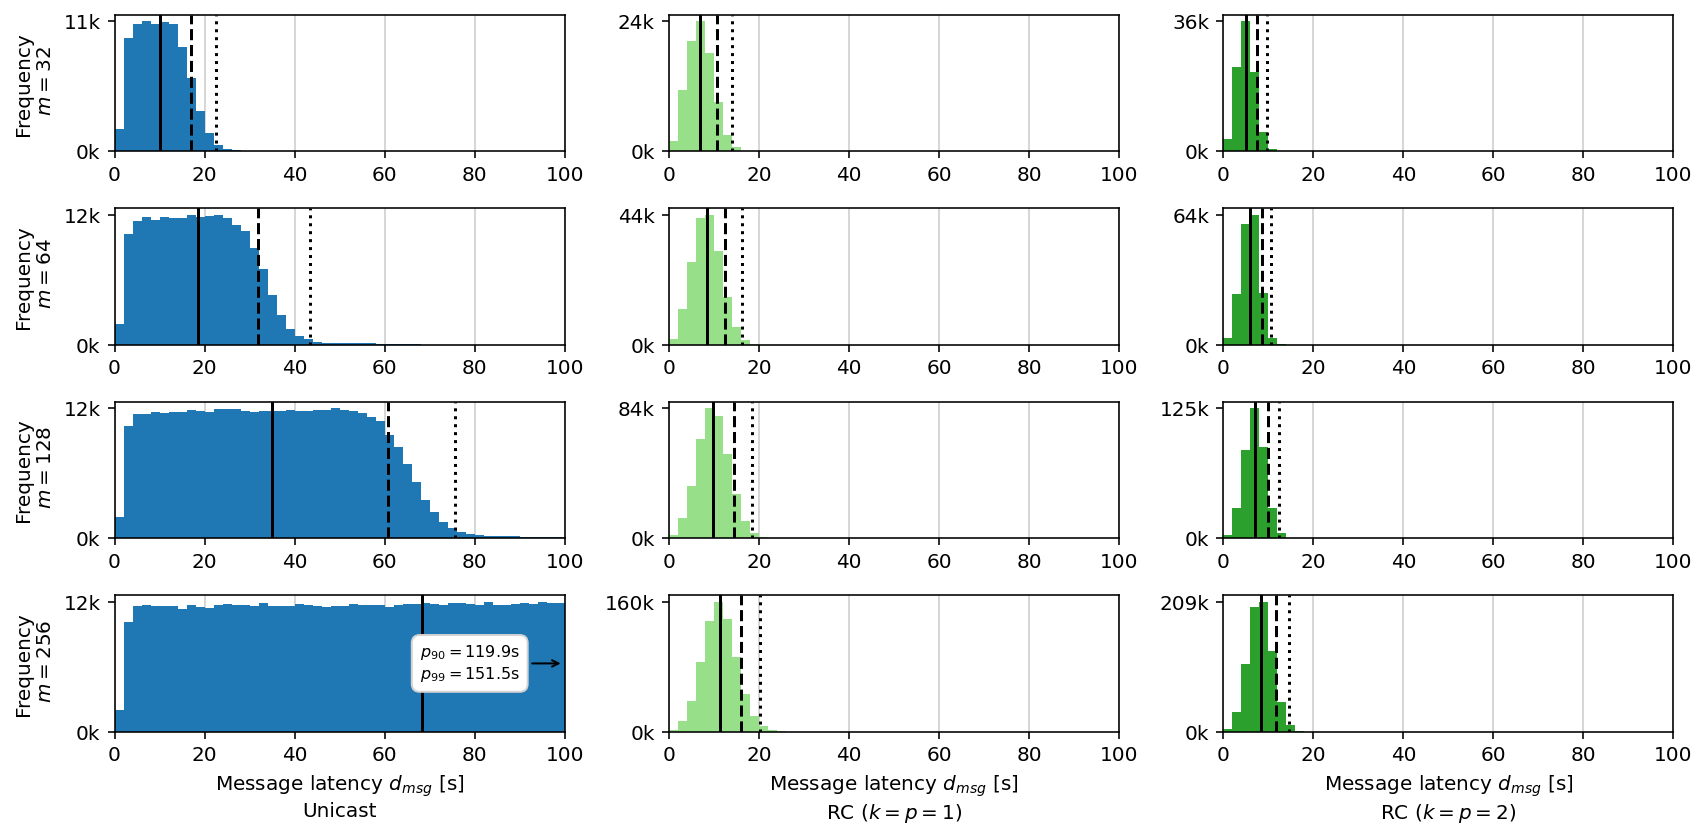

In [22]:
#
# Figure 15 in Appendix H (only in the extended paper)
#

fig = hist_plot(
    filter_results(online_data, config_name=online_config_name),
    y_grouping='m', y_values=[32, 64, 128, 256],
    x_grouping='strategy_name', x_values=ONLINE_STRATEGIES[:3],
    figsize=(12, 6),
    link_y=False,
    show_outliers=True,
)
plot_and_save(fig, "graph_online_hist", True)

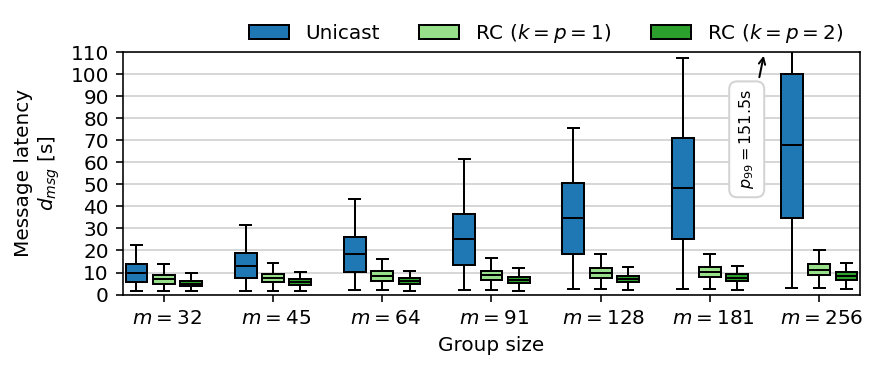

In [23]:
#
# Figure 5 in the paper
#

fig, ax, handles_labels = bar_plot(
    filter_results(online_data, config_name=online_config_name, schedule_name='online'),
    y_grouping='m', y_values=[x[0] for x in ONLINE_GROUP_SIZES], y_grouping_label='Group size',
    x_grouping='strategy_name', x_values=[ONLINE_STRATEGIES[x] for x in (0,1,2)],
    figsize=(6.25, 2.5),
    ylim=110,
    show_legend=False
)

m181_p99 = np.quantile(filter_results(online_data, config_name=online_config_name, schedule_name='online',m=181,strategy_name='unicast')[0].e2e_entries_online_d, 0.99)
if m181_p99 > 110 * 1000:
    ax.annotate(
        '$p_{99}=%.1f$s' % (m181_p99 / 1000),
        xy=(19,110_000),
        xytext=(18,60_000), ha="left",
        size=8,
        rotation=90,
        arrowprops=dict(arrowstyle="->"),
        bbox=dict(boxstyle="round,pad=0.5", fc="white",ec='lightgrey',lw=1),
    )

m256_p99 = np.quantile(filter_results(online_data, config_name=online_config_name, schedule_name='online',m=256,strategy_name='unicast')[0].e2e_entries_online_d, 0.99)
ax.annotate(
    '$p_{99}=%.1f$s' % (m256_p99 / 1000),
    xy=(23,110_000),
    xytext=(22,50_000), ha="left",
    size=8,
    rotation=90,
    arrowprops=dict(arrowstyle="->"),
    bbox=dict(boxstyle="round,pad=0.5", fc="white",ec='lightgrey',lw=1),
)


add_figure_legend(fig, ax, handles_labels, offset=0.07)
plot_and_save(fig, "graph_online_bar", True)

## Offline

In [24]:
offline_config_name = 'rs'

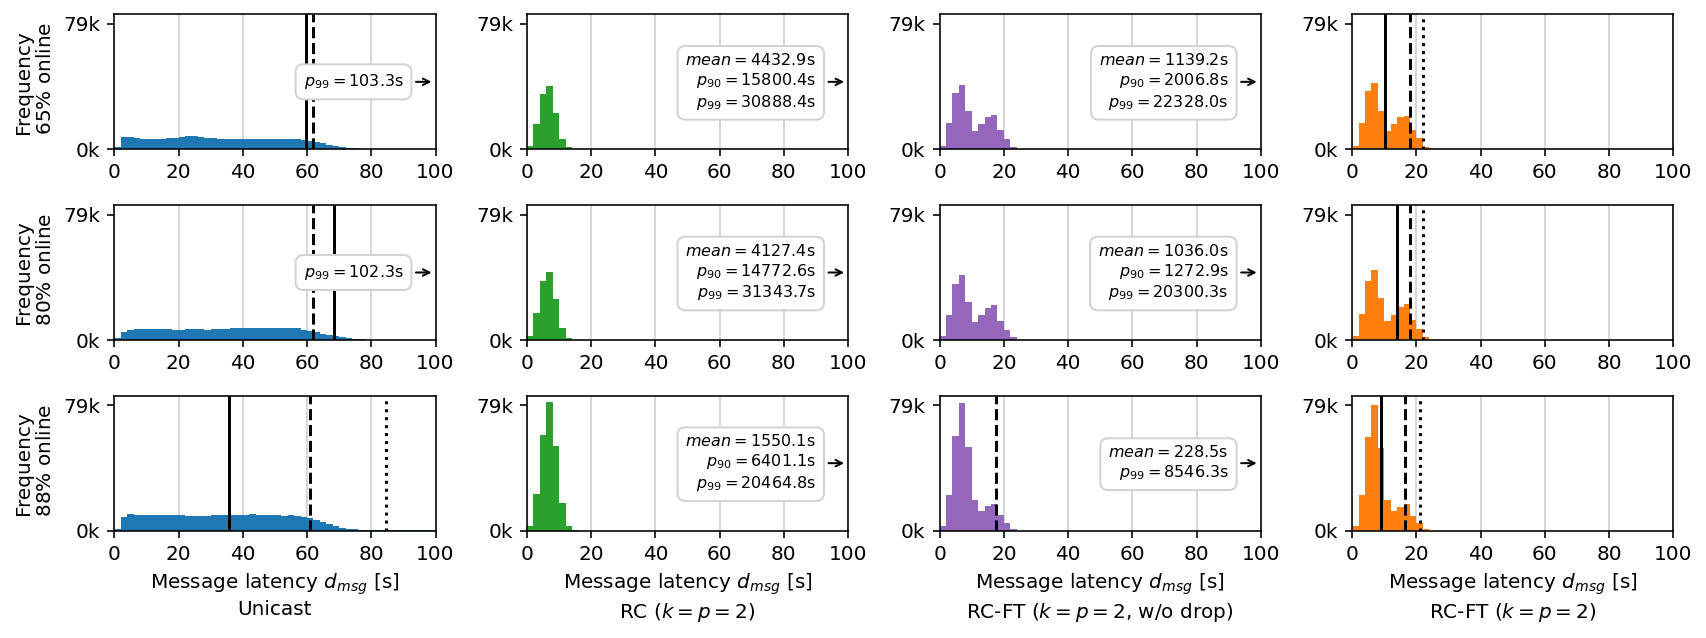

In [25]:
#
# Figure 16 in Appendix H (only in the extended paper)
#

fig = hist_plot(
    filter_results(offline_hist_data, group_sizes=[128], config_name=offline_config_name),
    y_grouping='schedule_name', y_values=OFFLINE_SCHEDULES,
    x_grouping='strategy_name', x_values=[OFFLINE_HIST_STRATEGIES[x] for x in (0,1,4,3)],
    figsize=(12, 4.6),
    link_y=True,
    show_outliers=True,
)
plot_and_save(fig, "graph_offline_hist", True)

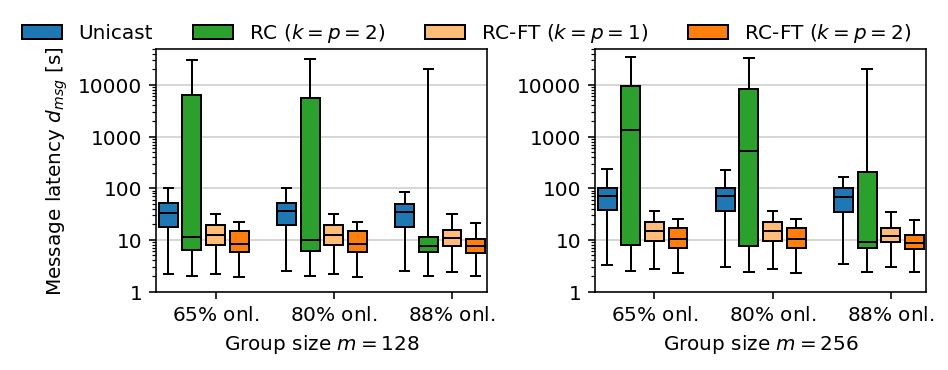

In [26]:
#
# Figure 6 in the paper
#

fig = plt.figure(figsize=(6.5, 2.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

_, ax1, handles_labels = bar_plot(
    filter_results(offline_data, group_sizes=[128], config_name=offline_config_name),
    y_grouping='schedule_name', y_values=OFFLINE_SCHEDULES,
    x_grouping='strategy_name', x_values=OFFLINE_STRATEGIES,
    ax=ax1,
    ylim=50_000, use_log=True,
    show_legend=False,
)
ax1.set_ylabel("Message latency $d_{msg}$ [s]")
ax1.set_xlabel("Group size $m=128$")
ax1.set_xticklabels(['$65\%$ onl.', '$80\%$ onl.', '$88\%$ onl.'])

_, ax2, handles_labels = bar_plot(
    filter_results(offline_data, group_sizes=[256], config_name=offline_config_name),
    y_grouping='schedule_name', y_values=OFFLINE_SCHEDULES,
    x_grouping='strategy_name', x_values=OFFLINE_STRATEGIES,
    ax=ax2,
    ylim=50_000, use_log=True,
    show_legend=False,
)
ax2.set_ylabel(None)
ax2.set_xlabel("Group size $m=256$")
ax2.set_xticklabels(['$65\%$ onl.', '$80\%$ onl.', '$88\%$ onl.'])

add_figure_legend(fig, ax1, handles_labels, offset=0.085, ncols=4)
plot_and_save(fig, "graph_offline_bar", True)

## Multigroup

In [27]:
multigroup_config_name = 'rs'
multigroup_strategies = [MULTIGROUP_STRATEGIES[x] for x in (0, 1, 2)]
MULTIGROUP_GROUPS = [x[1] for x in MULTIGROUP_GROUP_SIZES]

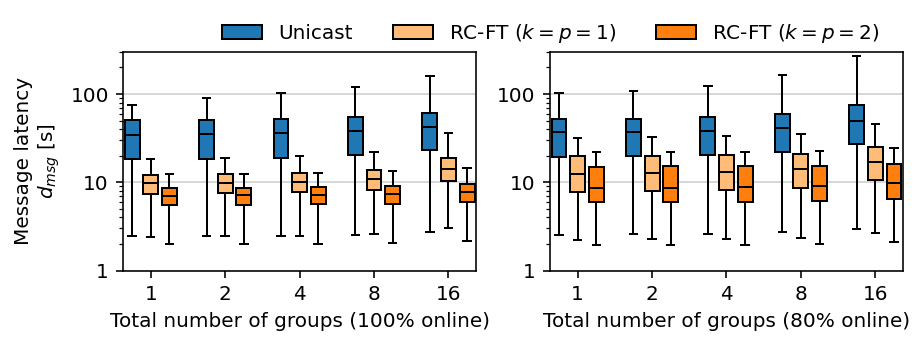

In [28]:
#
# Figure 7 in the paper
#

fig = plt.figure(figsize=(6.5, 2.25))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

_, ax1, _ = bar_plot(
    filter_results(multigroup_data, schedule_name='online', m=128, config_name=multigroup_config_name),
    y_grouping='group_sizes', y_values=MULTIGROUP_GROUPS,
    x_grouping='strategy_name', x_values=multigroup_strategies,
    ax=ax1,
    ylim=300, use_log=True,
    show_legend=False,
)
ax1.set_xlabel('Total number of groups (100% online)')

_, ax2, handles_labels = bar_plot(
    filter_results(multigroup_data, schedule_name='gen_os15', m=128, config_name=multigroup_config_name),
    y_grouping='group_sizes', y_values=MULTIGROUP_GROUPS,
    x_grouping='strategy_name', x_values=multigroup_strategies,
    ax=ax2,
    ylim=300, use_log=True,
    show_legend=False,
)
ax2.set_ylabel(None)
ax2.set_xlabel('Total number of groups (80% online)')
add_figure_legend(fig, ax, handles_labels, offset=0.10)

plot_and_save(fig, "graph_multigroup_bar", True)

## Multimessage

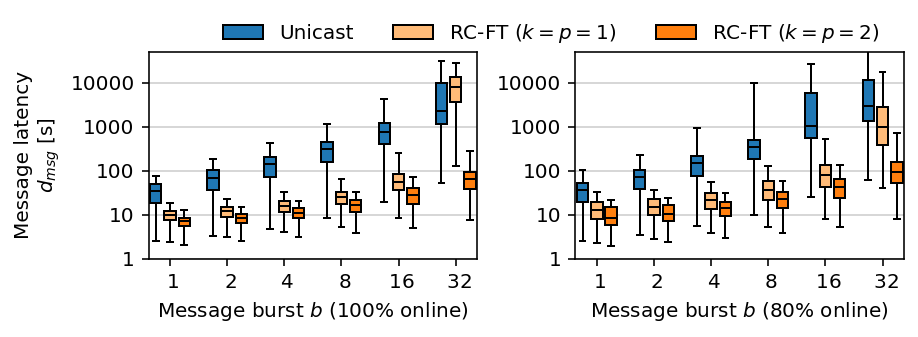

In [29]:
#
# Figure 8 in the paper
#

multimessage_strategies = MULTIMESSAGE_STRATEGIES[:]


fig = plt.figure(figsize=(6.5,2.25))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

_, ax1, _ = bar_plot(
    filter_results(multimessage_data, schedule_name='online', m=128, group_sizes=[128]),
    y_grouping='config_name', y_values=MULTIMESSAGE_CONFIGS,
    x_grouping='strategy_name', x_values=multimessage_strategies,
    ylim=50000, use_log=True,
    ax=ax1,
    show_legend=False,
)
ax1.set_yticks([1000*i for i in (1,10,100,1000,10000)])
ax1.set_xlabel('Message burst $b$ (100% online)')

_, ax1, handles_labels = bar_plot(
    filter_results(multimessage_data, schedule_name='gen_os15', m=128, group_sizes=[128]),
    y_grouping='config_name', y_values=MULTIMESSAGE_CONFIGS,
    x_grouping='strategy_name', x_values=multimessage_strategies,
    ylim=50000, use_log=True,
    ax=ax2,
    show_legend=False,
)
ax2.set_ylabel(None)
ax2.set_xlabel('Message burst $b$ (80% online)')
ax2.set_yticks([1000*i for i in (1,10,100,1000,10000)])
add_figure_legend(fig, ax, handles_labels, offset=0.10)

plot_and_save(fig, "graph_multimessage_bar", True)

## P-restricted VS lambda

In [30]:
import matplotlib.patheffects as path_effects

def heatmap(
    data,
    y_grouping, y_values, y_ticks,
    x_grouping, x_values, x_ticks,
    vmin, vmax,
    ax,
    cmap='RdYlGn_r',
    show_colorbar=False,
):

    table = group_results(
        data,
        y_grouping=y_grouping, y_values=y_values,
        x_grouping=x_grouping, x_values=x_values,
    )
    
    delays = []
    for y_idx, row in enumerate(table):
        curr_row = []
        for x_idx, col in enumerate(row.cols):
            curr_row.append(np.mean(col.d[0].e2e_entries_online_d) / 1000)
#             curr_row.append(np.quantile(col.d[0].e2e_entries_online_d, 0.9) / 1000)
        delays.append(curr_row)
    delays = np.array(delays)

    im = ax.imshow(delays, vmin=vmin, vmax=vmax, cmap=cmap, aspect='equal')
    if show_colorbar:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('mean $d_{msg}$', rotation=-90, va="bottom")

    ax.set_xticks(np.arange(len(x_values)))
    ax.set_xticklabels(x_ticks)

    ax.set_yticks(np.arange(len(y_values)))
    ax.set_yticklabels(y_ticks)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_values)):
        for j in range(len(x_values)):
            text = ax.text(
                j, i,
                "%.0f" % (delays[i, j]),
                ha="center", va="center",
                color="w",
                fontsize=8,
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal()
            ])

    return ax

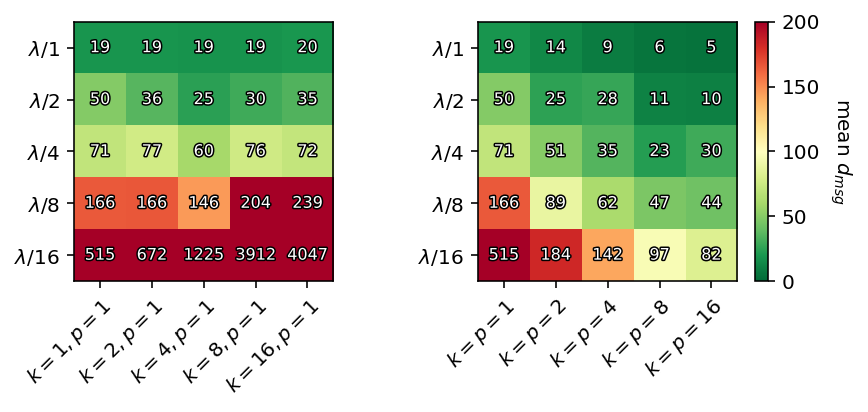

In [31]:
#
# Figure 9 in the paper
#

more_p_strategies = [
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p2-timeout10x-dropoffline', 
    'rollercoaster-k4-p4-timeout10x-dropoffline', 
    'rollercoaster-k8-p8-timeout10x-dropoffline', 
    'rollercoaster-k16-p16-timeout10x-dropoffline', 
]

constant_p_strategies = [
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p1-timeout10x-dropoffline', 
    'rollercoaster-k4-p1-timeout10x-dropoffline', 
    'rollercoaster-k8-p1-timeout10x-dropoffline', 
    'rollercoaster-k16-p1-timeout10x-dropoffline', 
]
p_factors = (1, 2, 4, 8, 16)


fig = plt.figure(figsize=(6.5,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1 = heatmap(
    filter_results(p_data, schedule_name='gen_os15', m=128, group_sizes=[128]),
    y_grouping='config_name', y_values=P_CONFIGS,
    y_ticks=['$\lambda / %d$' % x for x in p_factors],
    x_grouping='strategy_name', x_values=constant_p_strategies,
    x_ticks=['$k=%d,p=1$' % x for x in p_factors],
    vmin=0, vmax=200,
    ax=ax1,
)

ax2 = heatmap(
    filter_results(p_data, schedule_name='gen_os15', m=128, group_sizes=[128]),
    y_grouping='config_name', y_values=P_CONFIGS,
    y_ticks=['$\lambda / %d$' % x for x in p_factors],
    x_grouping='strategy_name', x_values=more_p_strategies,
    x_ticks=['$k=p=%d$' % x for x in p_factors],
    vmin=0, vmax=200,
    ax=ax2,
    show_colorbar=True,
)

plot_and_save(fig, "graph_p_vs_l_online_heatmap", True)

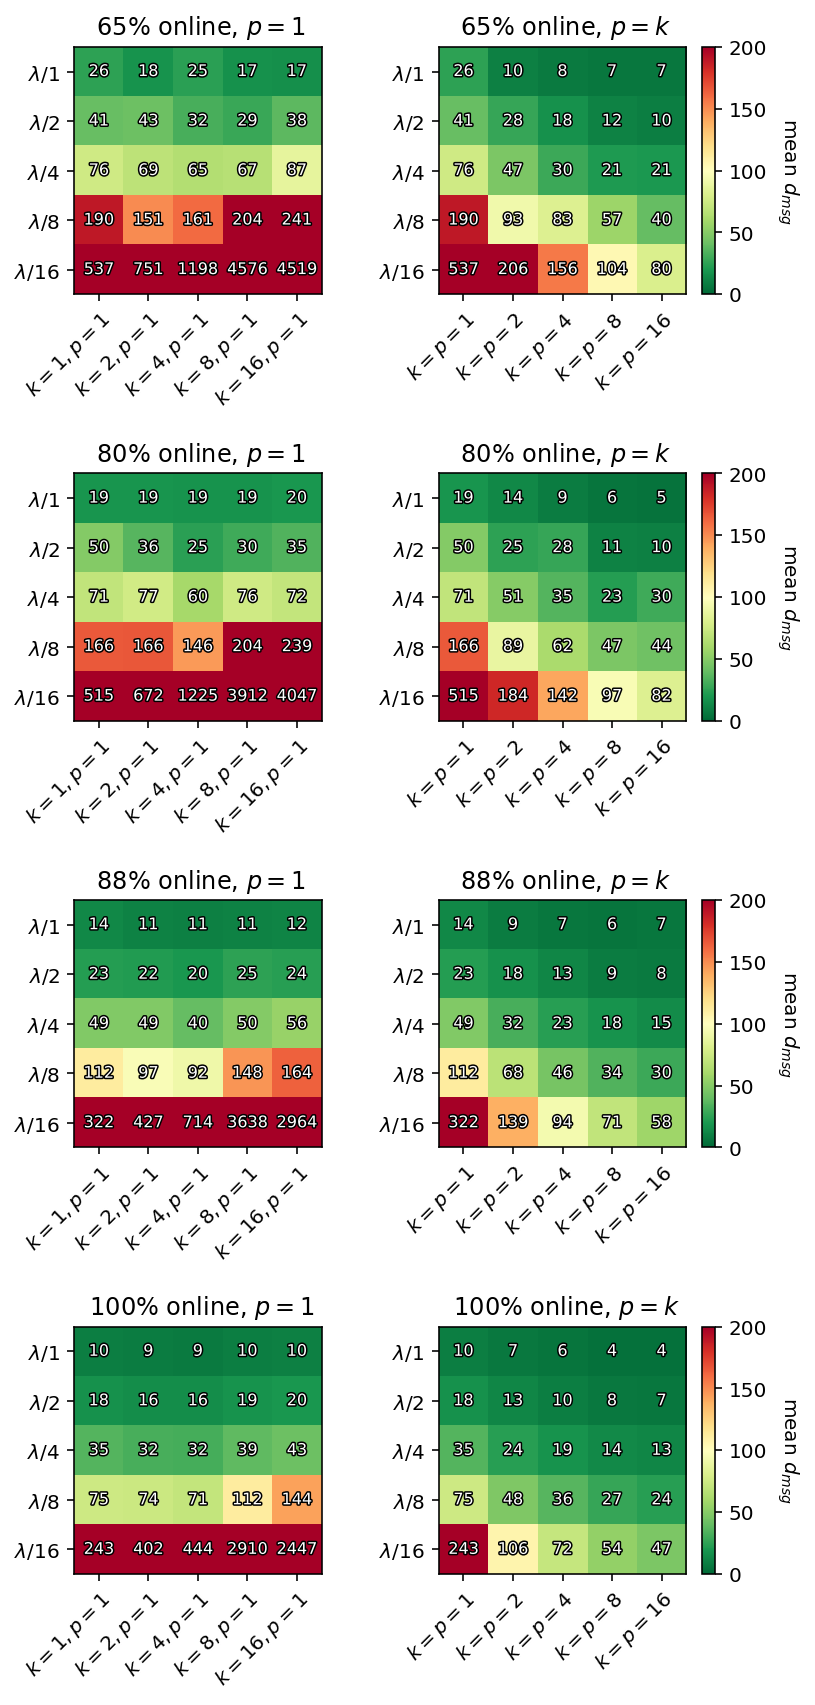

In [32]:
#
# Figure 14 in Appendix G (only in the extended paper)
# 

more_p_strategies = [
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p2-timeout10x-dropoffline', 
    'rollercoaster-k4-p4-timeout10x-dropoffline', 
    'rollercoaster-k8-p8-timeout10x-dropoffline', 
    'rollercoaster-k16-p16-timeout10x-dropoffline', 
]

constant_p_strategies = [
    'rollercoaster-k1-p1-timeout10x-dropoffline', 
    'rollercoaster-k2-p1-timeout10x-dropoffline', 
    'rollercoaster-k4-p1-timeout10x-dropoffline', 
    'rollercoaster-k8-p1-timeout10x-dropoffline', 
    'rollercoaster-k16-p1-timeout10x-dropoffline', 
]
p_factors = (1, 2, 4, 8, 16)


fig = plt.figure(figsize=(6,12))

schedules = [P_SCHEDULES[x] for x in (1,2,3,0)]
for row, schedule in enumerate(schedules):
    ax1 = fig.add_subplot(len(P_SCHEDULES), 2, 2*row+1)
    ax2 = fig.add_subplot(len(P_SCHEDULES), 2, 2*row+2)

    ax1 = heatmap(
        filter_results(p_data, schedule_name=schedule, m=128, group_sizes=[128]),
        y_grouping='config_name', y_values=P_CONFIGS,
        y_ticks=['$\lambda / %d$' % x for x in p_factors],
        x_grouping='strategy_name', x_values=constant_p_strategies,
        x_ticks=['$k=%d,p=1$' % x for x in p_factors],
        vmin=0, vmax=200,
        ax=ax1,
    )

    ax2 = heatmap(
        filter_results(p_data, schedule_name=schedule, m=128, group_sizes=[128]),
        y_grouping='config_name', y_values=P_CONFIGS,
        y_ticks=['$\lambda / %d$' % x for x in p_factors],
        x_grouping='strategy_name', x_values=more_p_strategies,
        x_ticks=['$k=p=%d$' % x for x in p_factors],
        vmin=0, vmax=200,
        ax=ax2,
        show_colorbar=True,
    )
    
    ax1.set_title(get_category_value_label('schedule_name', schedule) + ', $p=1$')
    ax2.set_title(get_category_value_label('schedule_name', schedule) + ', $p=k$')

plot_and_save(fig, "graph_p_vs_l_heatmap_appendix", True)

# Result variables

In [33]:
#
# These results are included in the main text of the paper via LaTeX variables
#

def print_cmd(name, value):
    print("\\newcommand{\\%s}{%.1f}" % (name, value))
    
def print_p99_cmd(name, data):
    assert len(data) == 1
    print_cmd(name, p99(data[0].e2e_entries_online_d))
    
def print_p90_cmd(name, data):
    assert len(data) == 1
    print_cmd(name, p90(data[0].e2e_entries_online_d))
    
def print_mean_cmd(name, data):
    assert len(data) == 1
    print_cmd(name, np.average(data[0].e2e_entries_online_d) / 1000)
    
def p99(x):
    return np.quantile(x, 0.99) / 1000
    
def p90(x):
    return np.quantile(x, 0.90) / 1000

print("% percentile always p99; except PercentilaSmall which is p90")
print("% large = 128")
print("% verylarge = 256")

print_p99_cmd(
    "measurementPercentileOnlineLargeRc",
    filter_results(online_data, m=128, schedule_name='online', strategy_name='rollercoaster-k2-p2-notimeout')
)
print_p99_cmd(
    "measurementPercentileOnlineLargeUnicast",
    filter_results(online_data, m=128, schedule_name='online', strategy_name='unicast')
)
print_p90_cmd(
    "measurementPercentileSmallOnlineLargeRc",
    filter_results(online_data, m=128, schedule_name='online', strategy_name='rollercoaster-k2-p2-notimeout')
)
print_p90_cmd(
    "measurementPercentileSmallOnlineLargeUnicast",
    filter_results(online_data, m=128, schedule_name='online', strategy_name='unicast')
)

print_p99_cmd(
    "measurementPercentileOfflineLargeRc",
    filter_results(offline_data, m=128, schedule_name='gen_os10', strategy_name='rollercoaster-k2-p2-timeout10x-dropoffline')
)
print_p99_cmd(
    "measurementPercentileOfflineLargeUnicast",
    filter_results(offline_data, m=128, schedule_name='gen_os10', strategy_name='unicast')
)
print_p90_cmd(
    "measurementPercentileSmallOfflineLargeRc",
    filter_results(offline_data, m=128, schedule_name='gen_os10', strategy_name='rollercoaster-k2-p2-timeout10x-dropoffline')
)
print_p90_cmd(
    "measurementPercentileSmallOfflineLargeUnicast",
    filter_results(offline_data, m=128, schedule_name='gen_os10', strategy_name='unicast')
)

print_mean_cmd(
    "measurementMeanOnlineLargeRc",
    filter_results(online_data, m=128, schedule_name='online', strategy_name='rollercoaster-k2-p2-notimeout')
)
print_mean_cmd(
    "measurementMeanOnlineLargeUnicast",
    filter_results(online_data, m=128, schedule_name='online', strategy_name='unicast')
)

print_mean_cmd(
    "measurementMeanOnlineVeryLargeRc",
    filter_results(online_data, m=256, schedule_name='online', strategy_name='rollercoaster-k2-p2-notimeout')
)

% percentile always p99; except PercentilaSmall which is p90
% large = 128
% verylarge = 256
\newcommand{\measurementPercentileOnlineLargeRc}{12.3}
\newcommand{\measurementPercentileOnlineLargeUnicast}{75.6}
\newcommand{\measurementPercentileSmallOnlineLargeRc}{9.9}
\newcommand{\measurementPercentileSmallOnlineLargeUnicast}{60.8}
\newcommand{\measurementPercentileOfflineLargeRc}{21.9}
\newcommand{\measurementPercentileOfflineLargeUnicast}{103.3}
\newcommand{\measurementPercentileSmallOfflineLargeRc}{18.0}
\newcommand{\measurementPercentileSmallOfflineLargeUnicast}{61.9}
\newcommand{\measurementMeanOnlineLargeRc}{7.0}
\newcommand{\measurementMeanOnlineLargeUnicast}{34.9}
\newcommand{\measurementMeanOnlineVeryLargeRc}{8.3}
